In [28]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] / len(df) * 10000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
        self.break_up_price = None
        self.break_down_price = None
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.1
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, period=5, amp=0.01, slope=1):
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()        
                
        # 1. 根据 close 与 ema_10 的关系标记方向
        bars['direction'] = np.where(bars['close'] > bars['ema_10'], 'above', 'below')
        # 2. 利用相邻变化生成组号
        bars['group_id'] = (bars['direction'] != bars['direction'].shift()).cumsum()
        # 3. 对每个组统计最小值、最大值和计数
        group_stats = bars.groupby('group_id')['close'].agg(['min', 'max', 'count']).rename(columns={'count': 'n'})
        # 4. 计算波动幅度（百分比），注意防止除零问题
        group_stats['amp'] = group_stats.apply(lambda row: (row['max'] - row['min']) / row['min'] if row['min'] > 0 else 0, axis=1)
        # 5. 筛选出满足连续至少5分钟且波动大于0.5%的组
        valid_groups = group_stats[(group_stats['n'] >= period) & (group_stats['amp'] > amp)].index
        # 6. 初始化 slope 列
        group_stats['slope'] = np.nan

        # 7. 计算每个 valid_group 的 slope
        for group_id in valid_groups:
            group_df = bars[bars['group_id'] == group_id]
            _slope = fit_piecewise_segments(group_df, 'date', 'ema_10', count=1)
            group_stats.at[group_id, 'slope'] = _slope

        # 8. 根据 slope 进一步筛选 valid_groups（例如 slope > 0.01）
        final_groups = group_stats[(group_stats['slope'].notna()) & (group_stats['slope'].abs() > slope)].index
        # print(group_stats[(group_stats['slope'].notna()) & (group_stats['slope'].abs() > slope)])
        # 9. 标记符合最终条件的 group
        bars['rapid_stretch'] = bars['group_id'].isin(final_groups)

        bars['signal'] = pd.Series(np.nan, dtype='object')  # 确保数据类型为字符串兼容
        for group_id in final_groups:
            group_df = bars[bars['group_id'] == group_id]
            last_idx = group_df.index[-1]

            # 根据 slope 标记 BUY 或 SELL
            bars.at[last_idx, 'signal'] = 'SELL' if group_stats.at[group_id, 'slope'] > 0 else 'BUY'
            
        # 10. 清理临时列
        bars.drop(columns=['direction', 'group_id'], inplace=True)
        return bars
    
    def get_open_signal(self, bars):
        if (bars.iloc[-1]["close"] > self.break_up_price and bars.iloc[-2]["close"] < self.break_up_price):
            return "做多"
        if (bars.iloc[-1]["close"] < self.break_down_price and bars.iloc[-2]["close"] > self.break_down_price):
            return "做空"

    def get_close_signal(self, position, bars):
        """
        返回格式 减仓比例, 减仓原因
        减仓条件：
        1. 开仓后价格直接回到成交时的区间中轨，平仓（强制）
        2. 从最高点回落一半,平半仓（假突破）,回落到开仓价位以下时，再平半仓
        3. 如果走出单边走势,破ema10, 区间长度需要超过10分钟(止盈)
        """
        amount = position["amount"]
        
        ## 条件一
        # middle_price = (self.break_up_price + self.break_down_price) / 2
        # if (bars.iloc[-1]["close"] < middle_price and amount > 0) or \
        #     (bars.iloc[-1]["close"] > middle_price and amount < 0):
        #         # print(f'开仓时的时间点{self.open_position_df.iloc[0]["date"]}-{self.open_position_df.iloc[-1]["date"]} 中枢价格{middle_price} 当前价格{bars.iloc[-1]["close"]}')
        #         return 1, f"价格回落开仓区间中枢"
        
        ## 条件二
        df = bars[bars["date"] >= position["date"]]
        
        drawdown_ratio = 0.5
        max_profit_price = df["close"].min() if amount < 0 else df["close"].max()
        init_price = df.iloc[0]["close"]
        current_price = df.iloc[-1]["close"]
        # 区域限定的mask
        post_buy_pattern = None
        mask = (max_profit_price > current_price > init_price and amount > 0) or \
                (max_profit_price < current_price < init_price and amount < 0)
        # 回落比例 = (max_profit_price - current_price) / (max_profit_price - current_price)
        if len(df) > 3 \
            and (max_profit_price - init_price) != 0 \
            and (max_profit_price - current_price) / (max_profit_price - init_price) >= drawdown_ratio \
            and mask \
            and abs((current_price - init_price) / init_price) >= 0.002 \
            and position["amount"] == position["init_amount"]:
                post_buy_pattern = "回落走势"
                return 0.5, f"从最高点回落超过{drawdown_ratio}"
            
        if post_buy_pattern == "回落走势" \
            and ((current_price < init_price and amount > 0) or (current_price > init_price and amount < 0)):
            return 0.5, f"从最高点回落超过{drawdown_ratio}"
        
    def update(self, bars):
        if self.break_up_price is None: return
        if len(bars) < 2: return
        # 反手信号（平仓部分）
        position = self.find_position()
        open_single = self.get_open_signal(bars)
        if open_single:
            direction = 1 if open_single == "做多" else -1
            if position and direction * position["amount"] < 0:
                self.pm.close_position(position, bars)
        
        # 开仓信号
        position = self.find_position()
        if open_single and not position and not is_within_specific_minutes_of_close(bars, 60):
            direction = 1 if open_single == "做多" else -1
            amount = direction * self.calculate_open_amount(bars)
            self.pm.open_position(self.contract, "Trend", amount, bars)

        # 收盘前平仓
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 1):
            self.pm.close_position(position, bars)
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        self.sideways_count = 0
        self.has_trade_count = 0
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

        if len(bars) == 390:
            self.trend[contract.symbol].break_up_price = None
            self.trend[contract.symbol].break_down_price = None
            self.trend[contract.symbol].setParams(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-03-25"
    duration_str = "200 D"
    # ba.minutes_backtest(end_date, duration_str)
finally:
    if ba.ib:
        ba.ib.disconnect()

In [29]:
from PlotPlus import PlotPlus

0 2024-06-06
                         date   open   high    low  close  volume  average  \
42  2024-06-06 10:12:00-04:00  89.62  89.76  89.47  89.57   14332   89.646   
67  2024-06-06 10:37:00-04:00  87.55  87.66  87.44  87.59   29365   87.554   
112 2024-06-06 11:22:00-04:00  86.25  86.43  86.12  86.18   21635   86.241   
148 2024-06-06 11:58:00-04:00  84.03  84.09  83.89  84.00   48267   83.994   
165 2024-06-06 12:15:00-04:00  83.24  83.47  83.22  83.29   18536   83.360   

     barCount     ema_10  rapid_stretch signal  
42         99  89.633643           True    BUY  
67        217  87.614758           True    BUY  
112       159  86.429795           True    BUY  
148       217  84.012476           True    BUY  
165       131  83.345711           True    BUY  


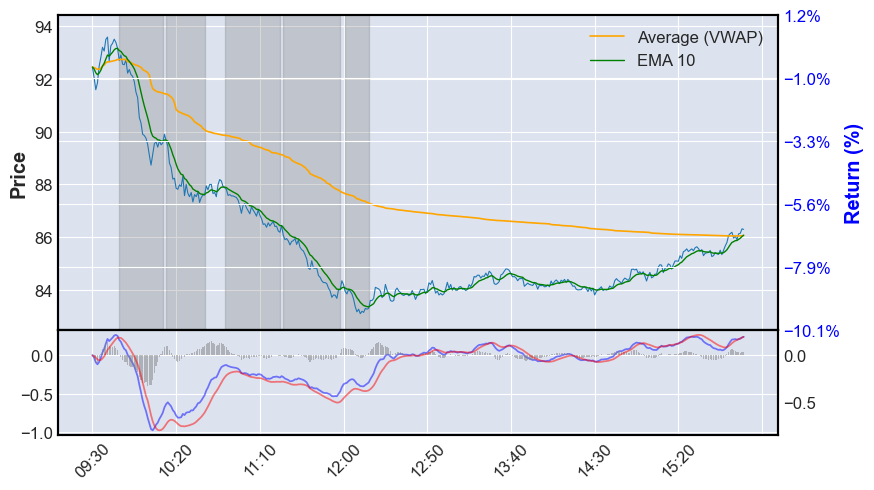

In [30]:
idx = 0
while True:
    daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, period=15, amp=0.01, slope=5)
    print(df[~df['signal'].isna()])
    pp = PlotPlus(df)
    pp.plot_basic()
    pp.mark_segment("rapid_stretch")
    # pp.mark_bs_point(ba.pm.trade_log)
    pp.mark_bs_point([])
    pp.show()
    break

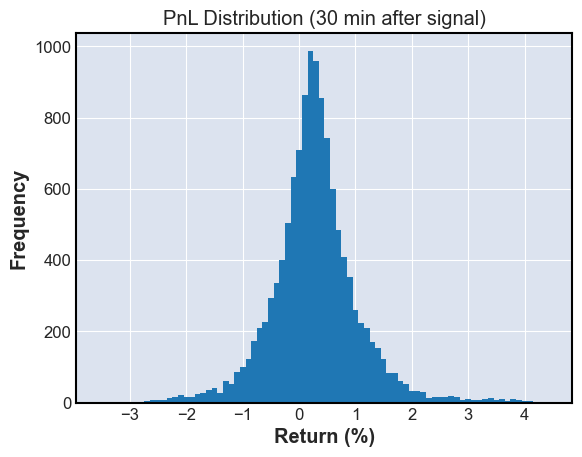

In [31]:
from collections import defaultdict
import matplotlib.pyplot as plt

bin_counter = defaultdict(int)  # 统计Bin

daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
idx = 0
while idx < len(daily):
    date = daily.iloc[idx]['date']
    idx += 1

    # 获取当天的分钟行情数据
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, period=15, amp=0.01, slope=5)

    # 筛选出带有 signal 的行
    signals = df[df['signal'].notna()].copy()

    # 过滤信号晚于收盘前30分钟的情况
    market_close = df.iloc[-1]["date"]
    signals = signals[signals['date'] <= market_close - pd.Timedelta(minutes=30)]

    for o_idx, signal in signals.iterrows():
        open_time = signal['date']
        open_price = signal['close']
        direction = 1 if signal['signal'] == 'BUY' else -1

        future = df.iloc[(signal.name + 1):(signal.name + 1 + 30)].copy()
        future['return'] = (future['close'] - open_price) / open_price * 100 * direction

        # 统计各Bin
        for ret in future['return']:
            bin_value = round(ret, 1)  # 以0.1%为步长
            bin_counter[bin_value] += 1

plt.bar(bin_counter.keys(), bin_counter.values(), width=0.1)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.title('PnL Distribution (30 min after signal)')
plt.show()

In [32]:
ba.statistic()

{'cumulative_pnl': 0,
 'max_drawdown': 0,
 'volatility': 0,
 'sharpe_ratio': 0,
 'daily_return': 0,
 'commission': 0}

In [33]:
ba.plot_pnl()

KeyError: 'date'

<Figure size 1000x600 with 0 Axes>